This is a reimplementation of fastai part 2 version 3 in Swift. https://github.com/fastai/fastai_docs/blob/master/dev_course/dl2/03_minibatch_training.ipynb

In [1]:
%install '.package(url: "https://github.com/mxcl/Path.swift", from: "0.16.1")' Path

Installing packages:
	.package(url: "https://github.com/mxcl/Path.swift", from: "0.16.1")
		Path
With SwiftPM flags: []
Working in: /tmp/tmp4wyjq4xd
Fetching https://github.com/mxcl/Path.swift
Completed resolution in 1.92s
Cloning https://github.com/mxcl/Path.swift
Resolving https://github.com/mxcl/Path.swift at 0.16.2
Compile Swift Module 'Path' (9 sources)
Compile Swift Module 'jupyterInstalledPackages' (1 sources)
Linking ./.build/x86_64-unknown-linux/debug/libjupyterInstalledPackages.so
Initializing Swift...
Loading library...
Installation complete!


In [2]:
import Path
import TensorFlow
import Foundation

## //TODO add plots

In [3]:
import Python

In [4]:
let np = Python.import("numpy")
let plt = Python.import("matplotlib.pyplot")

In [5]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


Load in the data

In [6]:
func loadData<Scalar: TensorFlowNumeric>(
    path: String, shape: [Int], is_label: Bool
) -> Tensor<Scalar> {
    let dropK: Int = (is_label ? 8 : 16)
    let data = try! Data.init(contentsOf: 
                     URL.init(fileURLWithPath: path)
                    ).dropFirst(dropK)
    let tensorShape = TensorShape.init(shape)
    let outTensor = Tensor<Float>(data.map(Float.init)).reshaped(to: tensorShape)
    return Tensor<Scalar>(outTensor)
}

In [7]:
let basepath = Path.home/".fastai"/"data"/"mnist"
let trnImgs = "train-images-idx3-ubyte"
let trnLbls = "train-labels-idx1-ubyte"
let valImgs = "t10k-images-idx3-ubyte"
let valLbls = "t10k-labels-idx1-ubyte" 

In [8]:
let xTrain: Tensor<Float> = loadData(path: (basepath/trnImgs).string,
                   shape: [60000, 784],
                   is_label: false)/255

In [9]:
let yTrain: Tensor<Int32> = loadData(path: (basepath/trnLbls).string,
                   shape: [60000],
                   is_label: true)

In [10]:
let xValid: Tensor<Float> = loadData(path: (basepath/valImgs).string,
                   shape: [10000, 784],
                   is_label: false)/255

In [11]:
let yValid: Tensor<Int32> = loadData(path: (basepath/valLbls).string,
                   shape: [10000],
                   is_label: true)

In [12]:
public extension Tensor where Scalar : TensorFlowFloatingPoint {
    func stddev(alongAxes axes: [Int])-> Tensor<Scalar>{
        let mean = self.mean(alongAxes: axes)
        return sqrt((self - mean).squared().mean(alongAxes: axes))
    }
    
    func stddev()-> Tensor<Scalar>{
        let mean = self.mean()
        return sqrt((self - mean).squared().mean())
    }
}

In [13]:
func normalize<Scalar: TensorFlowFloatingPoint>(
    _ x: Tensor<Scalar>, _ mean: Tensor<Scalar>? = nil, _ stddev: Tensor<Scalar>? = nil
) ->  Tensor<Scalar>{
    var mean = (mean ?? x.mean())
    var stddev = (stddev ?? x.stddev())
    return (x-mean)/stddev
}

In [14]:
var xTrainNormal: Tensor<Float> = normalize(xTrain)
var xValidNormal: Tensor<Float> = normalize(
    xValid,
    xTrain.mean(),
    xTrain.stddev()
)

In [15]:
public struct Model<Scalar: TensorFlowFloatingPoint>: Layer {
    public var linear1: Dense<Scalar>
    public var linear2: Dense<Scalar>

    public init(_ nIn: Int, _ nHidden: Int, _ nOut: Int){
        self.linear1 = Dense(inputSize: nIn, outputSize: nHidden, activation: relu)
        self.linear2 = Dense(inputSize: nHidden, outputSize: nOut)
    }

    @differentiable
    public func call(_ input: Tensor<Scalar>) -> Tensor<Scalar> {
        return input.sequenced(through: linear1, linear2)
    }
}

In [16]:
let n: Int = xTrainNormal.shape[0]
let m: Int = xTrainNormal.shape[1]
let c: Int = Int(yTrain.max().scalarized()) + 1
let nh: Int = 50

In [17]:
print(n,m,c,nh)

60000 784 10 50


In [18]:
var model = Model<Float>(m, nh, c)

In [19]:
var preds = model(xTrainNormal)

## Cross entropy loss
First, we will need to compute the softmax of our activations. This is defined by:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{e^{x_{0}} + e^{x_{1}} + \cdots + e^{x_{n-1}}}$$

or more concisely:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum_{0 \leq j \leq n-1} e^{x_{j}}}$$

In practice, we will need the log of the softmax when we calculate the loss.

In [20]:
func logSoftmax<Scalar: FloatingPoint>(_ x: Tensor<Scalar>) -> Tensor<Scalar>{
    var eX = exp(x)
    return log(eX/eX.sum(alongAxes: -1))
}

In [21]:
var smPreds = logSoftmax(preds)

In [22]:
smPreds.shape

▿ TensorShape
  ▿ dimensions : 2 elements
    - 0 : 60000
    - 1 : 10


In [23]:
smPreds[0][5]

-1.0504041


In [24]:
Raw.gatherNd(params: smPreds, indices: Tensor<Int32>([[0, 5],[1, 0],[2, 4]]))

[-1.0504041, -3.5830793, -2.5765488]


In [25]:
func nll<Scalar: TensorFlowFloatingPoint, TI: TensorFlowInteger>(
    _ preds: Tensor<Scalar>, _ target: Tensor<TI>
) -> Tensor<Scalar>{
    let rng = Tensor<TI>(rangeFrom: TI(0), to: TI(preds.shape[0]), stride: TI(1))
    let idx: Tensor<TI> = Raw.concat(concatDim: Tensor(1),
                                [rng.expandingShape(at: -1), 
                                 Tensor<TI>(target.expandingShape(at: -1))])
    return -Raw.gatherNd(params: preds, indices: idx).mean()
}

In [26]:
nll(smPreds, yTrain)

2.8407245


Note that the formula:
$$\log \left ( \frac{a}{b} \right ) = \log(a) - \log(b)$$
gives a simplification when we compute the log softmax, which was previously defined as (x.exp()/(x.exp().sum(-1,keepdim=True))).log()


In [27]:
func logSoftmax<Scalar: FloatingPoint>(_ x: Tensor<Scalar>) -> Tensor<Scalar>{
    var eX = exp(x)
    return x - log(eX.sum(alongAxes: -1))
}

In [28]:
var smPreds = logSoftmax(preds)

In [29]:
nll(smPreds, yTrain)

2.8407245



Then, there is a way to compute the log of the sum of exponentials in a more stable way, called the [LogSumExp trick](https://en.wikipedia.org/wiki/LogSumExp). The idea is to use the following formula:
$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$
where a is the maximum of the $x_{j}$.

In [30]:
func logSumExp<Scalar: FloatingPoint>(_ x: Tensor<Scalar>) -> Tensor<Scalar>{
    var a = x.max(alongAxes: -1)
    return a + log(exp(x-a).sum(alongAxes: -1))
}

In [31]:
func logSoftmax<Scalar: FloatingPoint>(_ x: Tensor<Scalar>) -> Tensor<Scalar>{
    return x - logSumExp(x)
}

In [32]:
nll(logSoftmax(preds), yTrain)

2.8407245


And now S4TF's implementation

In [33]:
softmaxCrossEntropy(logits: preds, labels: yTrain)

2.8407245


## Basic training loop

Basically the training loop repeats over the following steps:

- get the output of the model on a batch of inputs
- compare the output to the labels we have and compute a loss
- calculate the gradients of the loss with respect to every parameter of the model
- update said parameters with those gradients to make them a little bit better

In [34]:
func accuracy<TF: TensorFlowFloatingPoint>(
    _ preds: Tensor<TF>, _ targets: Tensor<Int32>
)-> Tensor<TF>{
    return Tensor<TF>(preds.argmax(squeezingAxis: -1) .== targets).mean()
}

In [35]:
accuracy(preds, yTrain)

0.094


In [36]:
var bs = 64
var xb = xTrainNormal[0..<bs]
var preds = model(xb)

In [37]:
print(preds[0], preds.shape)

[-0.09960985,   0.7754209,   1.1765766,   1.3046979,   1.1709158,   2.5706964,   1.6591058,
   1.4501945,  0.12702267,   -0.871587] TensorShape(dimensions: [64, 10])


In [38]:
var yb = yTrain[0..<bs]
softmaxCrossEntropy(logits: preds, labels: yb)

2.9246294


In [39]:
accuracy(preds, yb)

0.078125


In [40]:
var lr: Float = 0.05
var epochs = 1

In [41]:
for epoch in 0..<epochs {
    for i in 0..<((n-1)/bs + 1){
        var start_i = i * bs
        var end_i = start_i + bs
        var xb = xTrainNormal[start_i..<end_i]
        var yb = yTrain[start_i..<end_i]
        
        var (preds, backprop) = model.appliedForBackpropagation(to: xb)
        var (loss, grad) = preds.valueWithGradient{preds in
                            softmaxCrossEntropy(logits: preds,  labels: yb)}
        var (𝛁model, _) = backprop(grad)
        
        //this is sort of like parameters in PyTorch
        for kp in model.allDifferentiableVariables.recursivelyAllWritableKeyPaths(to: Tensor<Float>.self){
            model.allDifferentiableVariables[keyPath: kp] -= 𝛁model[keyPath: kp] * lr
        }
    }
}

In [42]:
var preds = model(xb)
print(softmaxCrossEntropy(logits: preds,  labels: yb), accuracy(preds, yb))

0.101875655 0.953125


## Optimizer
Let's replace our previous manually coded optimization step:

```
for kp in model.allDifferentiableVariables.recursivelyAllWritableKeyPaths(to: Tensor<Float>.self){
    model.allDifferentiableVariables[keyPath: kp] -= 𝛁model[keyPath: kp] * lr
}
```
with:
```
opt.step(&model, 𝛁model)
```

In [43]:
public struct MyOptimizer<Model: Layer> {
    public var lr: Float

    public init(_ lr: Float=0.05){
        self.lr = lr
    }
    
    mutating public func step(
        _ model: inout Model, _ grad: Model.AllDifferentiableVariables
    ) {
        for kp in model.allDifferentiableVariables.recursivelyAllWritableKeyPaths(to: Tensor<Float>.self){
            model.allDifferentiableVariables[keyPath: kp] -= grad[keyPath: kp] * self.lr
        }
    }
}

In [44]:
var model = Model<Float>(m, nh, c)
var opt = MyOptimizer<Model<Float>>()

In [45]:
for epoch in 0..<epochs {
    for i in 0..<((n-1)/bs + 1){
        var start_i = i * bs
        var end_i = start_i + bs
        var xb = xTrainNormal[start_i..<end_i]
        var yb = yTrain[start_i..<end_i]
        
        var (preds, backprop) = model.appliedForBackpropagation(to: xb)
        var (loss, grad) = preds.valueWithGradient{preds in
                            softmaxCrossEntropy(logits: preds,  labels: yb)}
        var (𝛁model, _) = backprop(grad)

        opt.step(&model, 𝛁model)
    }
}

In [46]:
var preds = model(xb)
print(softmaxCrossEntropy(logits: preds,  labels: yb), accuracy(preds, yb))

0.16002208 0.953125


S4TF already provides similar functionality in ```SGD```

In [47]:
var model = Model<Float>(m, nh, c)
var opt = SGD(for: model, learningRate: lr)

In [48]:
for epoch in 0..<epochs {
    for i in 0..<((n-1)/bs + 1){
        var start_i = i * bs
        var end_i = start_i + bs
        var xb = xTrainNormal[start_i..<end_i]
        var yb = yTrain[start_i..<end_i]
        
        var (preds, backprop) = model.appliedForBackpropagation(to: xb)
        var (loss, grad) = preds.valueWithGradient{preds in
                            softmaxCrossEntropy(logits: preds,  labels: yb)}
        var (𝛁model, _) = backprop(grad)

        opt.update(&model.allDifferentiableVariables, along: 𝛁model)
    }
}

In [49]:
var preds = model(xb)
print(softmaxCrossEntropy(logits: preds,  labels: yb), accuracy(preds, yb))

0.11824095 0.96875


## Dataset

Previously, our loop iterated over batches (xb, yb) like this:
```
    for i in 0..<((n-1)/bs + 1){
        var start_i = i * bs
        var end_i = start_i + bs
        var xb = xTrainNormal[start_i..<end_i]
        var yb = yTrain[start_i..<end_i] 
        ...
    }
```
Let's make our loop much cleaner, using a DataSet:
```
    for batch in trainDataset.batched(bs){
        batch.inputs
        batch.labels
        ...
    }
```

In [50]:
public struct Batch<Inputs: Differentiable & TensorGroup, Labels: TensorGroup>: TensorGroup {
    public var inputs: Inputs
    public var labels: Labels
    
    init(_ inputs: Inputs, _ labels: Labels){
        (self.inputs, self.labels) = (inputs, labels)
    }
}

In [51]:
var trainDataset = Dataset<Batch>(elements: Batch(xTrainNormal, yTrain))

In [53]:
var it = trainDataset.makeIterator()
var img = np.asarray(it.next()!.inputs.array.scalars).reshape(28,28)

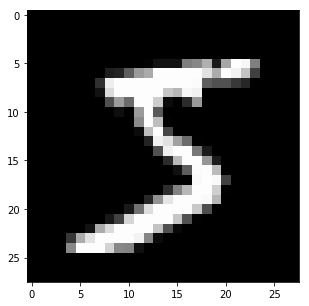

None


In [54]:
plt.figure(figsize: [5,5])
let fig = plt.imshow(X:img, cmap:"gray")
plt.show(fig)

In [55]:
var model = Model<Float>(m, nh, c)
var opt = SGD(for: model, learningRate: lr)

In [56]:
var bs = 64
var lr: Float = 0.05
var epochs = 1

In [57]:
for epoch in 0..<epochs {
    for batch in trainDataset.batched(bs){
        var (preds, backprop) = model.appliedForBackpropagation(to: batch.inputs)
        var (loss, grad) = preds.valueWithGradient{preds in
                            softmaxCrossEntropy(logits: preds,  labels: batch.labels)}
        var (𝛁model, _) = backprop(grad)

        opt.update(&model.allDifferentiableVariables, along: 𝛁model)
    }
}

In [58]:
var it = trainDataset.batched(bs).makeIterator()
var batch = it.next()!
var preds = model(batch.inputs)
print(softmaxCrossEntropy(logits: preds,  labels: batch.labels), accuracy(preds, batch.labels))

0.13320169 0.96875


with random shuffling

In [59]:
for epoch in 0..<epochs {
    for batch in trainDataset.batched(bs).shuffled(sampleCount: n, randomSeed: 3){
        var (preds, backprop) = model.appliedForBackpropagation(to: batch.inputs)
        var (loss, grad) = preds.valueWithGradient{preds in
                            softmaxCrossEntropy(logits: preds,  labels: batch.labels)}
        var (𝛁model, _) = backprop(grad)

        opt.update(&model.allDifferentiableVariables, along: 𝛁model)
    }
}

In [60]:
var batch = it.next()!
var preds = model(batch.inputs)
print(softmaxCrossEntropy(logits: preds,  labels: batch.labels), accuracy(preds, batch.labels))

0.1273525 0.96875


## Validation

You **always** should also have a [validation set](http://www.fast.ai/2017/11/13/validation-sets/), in order to identify if you are overfitting.

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call model.train() before training, and model.eval() before inference, because these are used by layers such as nn.BatchNorm2d and nn.Dropout to ensure appropriate behaviour for these different phases.)

In [61]:
func fit<Opt: Optimizer, Labels: TensorGroup>(
    epochs: Int,
    model: inout Opt.Model,
    opt: inout Opt,
    trainDs: Dataset<Batch<Opt.Model.Input, Labels>>,
    validDs: Dataset<Batch<Opt.Model.Input, Labels>>,
    lossFunc: @escaping @differentiable (_ logits: Tensor<Opt.Scalar>, _ labels: @nondiff Labels) -> Tensor<Opt.Scalar>
) where
    Opt.Model: Layer,
    Opt.Model.Input: TensorGroup,
    Opt.Scalar: TensorFlowFloatingPoint,
    Opt.Model.Output == Tensor<Opt.Scalar>
{
    for epoch in 0..<epochs {
        for batch in trainDs{
            var (_, 𝛁model) = model.valueWithGradient{
                model -> Tensor<Opt.Scalar> in
                    let preds = model(batch.inputs)
                    return lossFunc(preds,  batch.labels)}
            opt.update(&model.allDifferentiableVariables, along: 𝛁model)
        }

        var totalLoss = Tensor<Opt.Scalar>(0)
        var totalAccuracy = Tensor<Opt.Scalar>(0)
        var it = Opt.Scalar(0)
        for batch in validDs{
            let preds = model(batch.inputs)
            let loss = softmaxCrossEntropy(logits: preds, labels: batch.labels as! Tensor<Int32>)
            let acc = accuracy(preds, batch.labels as! Tensor<Int32>)
            totalLoss += loss
            totalAccuracy += acc
            it += Opt.Scalar(1)
        }
        print(epoch, totalLoss/it, totalAccuracy/it)
    }
}

In [62]:
var trainDataset = Dataset<Batch>(
    elements: Batch(xTrainNormal, yTrain)
).shuffled(sampleCount: n, randomSeed: 3).batched(bs)
var validDataset = Dataset<Batch>(
    elements: Batch(xValidNormal, yValid)
).batched(bs)

In [63]:
var bs = 64
var lr: Float = 0.05
var epochs = 1

In [64]:
var model = Model<Float>(m, nh, c)
var opt = SGD(for: model, learningRate: lr)

In [65]:
fit(epochs: 4, 
    model: &model,
    opt: &opt,
    trainDs: trainDataset,
    validDs: validDataset,
    lossFunc: softmaxCrossEntropy)

0 0.17526488 0.94994026
1 0.13379017 0.95899683
2 0.11517216 0.96536624
3 0.10422918 0.96924764
